## Part 3: Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014 is provided in 'ultimate_data_challenge.json'. The data was pulled several months later, and a user is considered retained if they were “active” in the preceding 30 days. 
<br>My task is to use this dataset to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
path = "../Takehome_challenge_3/ultimate_data_challenge.json"

In [3]:
df = pd.read_json(path)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There is some cleaning to do: I need to cast signup_date and last_trip_date to datetime type and decide how to handle the nulls in avg_rating_of_driver, phone, and avg_rating_by_driver. And first I will create a binary int column for whether a user is retained or not.

In [6]:
df["retained"]=np.where(df['trips_in_first_30_days']>=1, 1, 0)

In [7]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [8]:
df.value_counts(subset='retained')

retained
1    34610
0    15390
dtype: int64

In [9]:
#calculate % retained users
retained = df['retained'].value_counts()[1]
not_retained  = df['retained'].value_counts()[0]

pct = retained/(retained+not_retained)*100
print(f"Percent users retained: {pct}%")

Percent users retained: 69.22%


In [10]:
#cast date columns from objects to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  retained                50000 non-null  int32 

Now to handle the missing data. There are few enough missing values in the phone column that it should be fine to just impute with the mode. And likewise with the avg_rating_by_driver, there are few missing values, so I will impute with the median score of 5.0. Since there are about 15% missing values for the avg_rating_of_driver, choice of imputation is a little more delicate. We do not want to throw away almost 15% of the data for missing data in only one column, but imputing could introduce a bias: it is possible that the people who did not leave their driver a rating did not do so because they had a bad experience but felt guilty about leaving a bad rating. In this case imputing with the mean or median would introduce a significant bias. But we might just have to make some assumptions in order to impute the missing data in this column. I will have a look at some of the rows with null in this column and see if there is an obvious pattern. If not, maybe it will be a good sign to go ahead and impute with the average.

In [11]:
#let's view a selection of rows that are missing data in the avg_rating_of_driver col
df.query('`avg_rating_of_driver`.isnull()', engine='python').head(20)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0,1
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0,1
12,Winterfell,1,2014-01-15,NaN,1.00,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0,1
14,Astapor,1,2014-01-27,NaN,1.00,2014-01-28,Android,0.0,False,100.0,26.01,5.0,1
15,Winterfell,1,2014-01-15,NaN,1.00,2014-01-16,Android,0.0,True,100.0,13.20,5.0,1
20,Winterfell,1,2014-01-31,NaN,1.00,2014-03-16,Android,0.0,False,50.0,2.53,3.0,1
21,Astapor,1,2014-01-09,NaN,1.00,2014-04-29,iPhone,0.0,False,100.0,3.31,5.0,1
22,Winterfell,0,2014-01-24,NaN,1.00,2014-05-02,iPhone,0.0,False,100.0,11.47,5.0,0
25,Winterfell,1,2014-01-02,NaN,1.00,2014-01-03,iPhone,0.0,True,100.0,14.48,5.0,1
28,Winterfell,0,2014-01-19,NaN,1.50,2014-06-08,iPhone,100.0,False,0.0,5.97,5.0,0


In [12]:
df.query('`avg_rating_of_driver`.isnull()', engine='python').tail(20)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
49866,Astapor,1,2014-01-14,NaN,1.08,2014-04-10,iPhone,33.3,False,100.0,3.69,4.7,1
49884,Winterfell,1,2014-01-08,NaN,1.00,2014-01-27,iPhone,0.0,True,100.0,18.02,5.0,1
49886,King's Landing,0,2014-01-23,NaN,1.00,2014-06-22,iPhone,0.0,False,0.0,1.91,5.0,0
49891,Astapor,0,2014-01-06,NaN,1.50,2014-03-30,iPhone,100.0,False,0.0,1.07,3.0,0
49912,Winterfell,0,2014-01-14,NaN,1.00,2014-03-17,Android,0.0,False,0.0,1.27,5.0,0
49921,Winterfell,0,2014-01-08,NaN,1.00,2014-06-25,iPhone,0.0,True,100.0,19.74,5.0,0
49926,Astapor,1,2014-01-30,NaN,1.00,2014-01-31,iPhone,0.0,False,100.0,3.82,5.0,1
49927,Winterfell,2,2014-01-24,NaN,1.00,2014-02-16,Android,0.0,False,0.0,3.73,3.0,1
49947,Winterfell,1,2014-01-12,NaN,1.00,2014-01-28,iPhone,0.0,True,100.0,13.74,5.0,1
49951,Winterfell,0,2014-01-29,NaN,1.00,2014-04-16,Android,0.0,True,100.0,4.24,5.0,0


After inspecting a selection of the rows that are missing avg_rating_of_driver data, there is a wide range of variety in the other columns without any obvious pattern (including in the average_rating_by_driver column, so let's make the assumption that it is relatively safe to impute with the mean in this case.

In [13]:
#impute missing phone column with mode - must cast output of mode() as string
df['phone'] = df['phone'].fillna(str(df['phone'].mode()))

In [14]:
#impute missing avg_rating_by_driver with median
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())

In [15]:
#impute missing avg_rating_of_driver with mean
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int32 

In [17]:
#let's see what unique values there are for the categorical cols: city and phone
display(df['city'].unique(), df['phone'].unique())

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

array(['iPhone', 'Android', '0    iPhone\nName: phone, dtype: object'],
      dtype=object)

There is bit more cleaning to do with the phone column; I will also change any record with '0    iPhone\nName: phone, dtype: object' to the mode ('iPhone'). Also, since there are so few cities and phone types, I can one-hot encode them to keep them in the dataset for the predictive model.

In [18]:
df['phone'] = df['phone'].replace('0    iPhone\nName: phone, dtype: object', 'iPhone') #df['phone'] = df['phone'].replace('0', str(df['phone'].mode()))

In [19]:
df['phone'].value_counts()

iPhone     34978
Android    15022
Name: phone, dtype: int64

Before exploring some visuals of the data and its relationships, I will also convert the ultimate_black_user column from a boolean to a binary integer column, 0 for false and 1 for true, and one hot encode the phone and city columns.

So now that we have a clean dataset with no missing values, I will create some visualizations to explore the distributions of the data. A heatmap of all the variables can give insights for variable relationships to explore further.

C:\Users\ehard\AppData\Local\Temp\ipykernel_18020\1524288774.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(), cmap='PiYG')


Text(0.5, 1.03, 'Rider Feature Correlations')

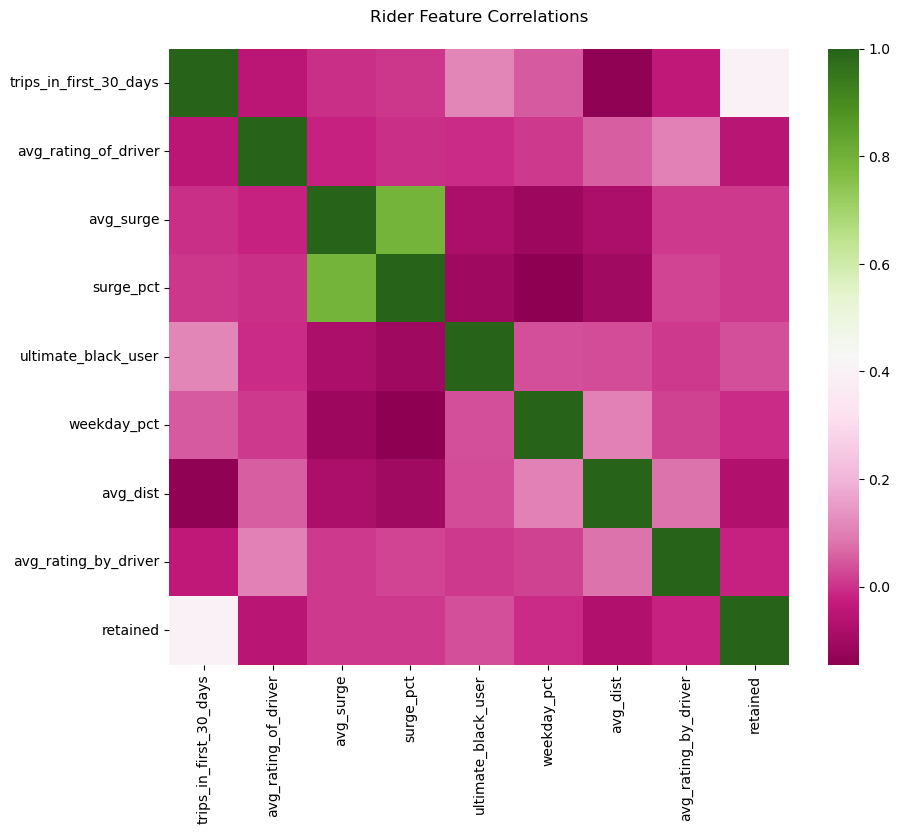

In [20]:
#let's try a heatmap on to view correlations between the variables
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(df.corr(), cmap='PiYG')
ax.set_title("Rider Feature Correlations",y=1.03)

There are no super strong correlations that jump out, but it appears there is a slight negative correlation between average distance (avg_dist) and trips_in_first_30_days, and a slight positive correlation between ultimate_black_user and trips_in_first_30_days. Those are two that are worth exploring further:

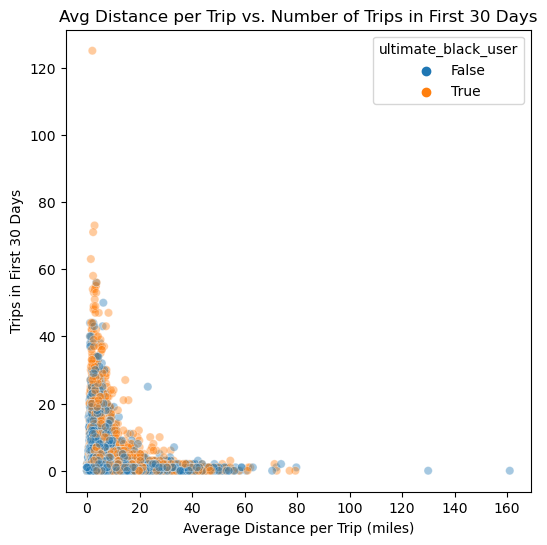

In [21]:
#Let's plot up some of the correlations we noted from the heatmap
#First, avg_dist vs trips_in_first_30_days 
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.scatterplot(data=df, x='avg_dist', y='trips_in_first_30_days', hue = 'ultimate_black_user', alpha = 0.4)

plt.xlabel('Average Distance per Trip (miles)')
plt.ylabel('Trips in First 30 Days')

plt.title("Avg Distance per Trip vs. Number of Trips in First 30 Days")
plt.show()

Text(0.5, 1.0, 'Avg Distance per Trip vs. Number of Trips in First 30 Days')

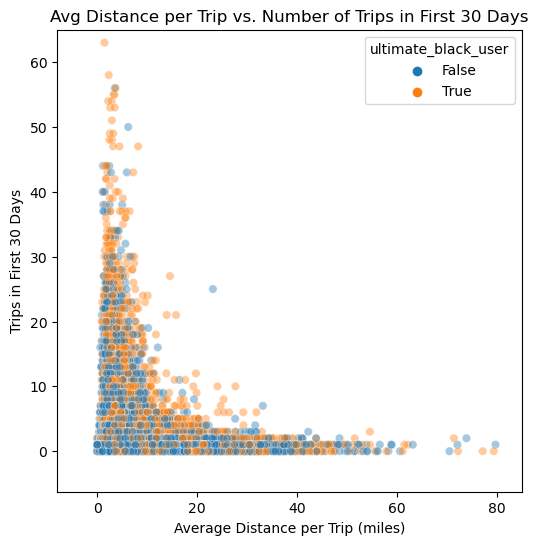

In [22]:
#let's show the same plot, but expoluding outliers so we can see the bulk of the data in more detail
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.scatterplot(data=df, x='avg_dist', y='trips_in_first_30_days', hue = 'ultimate_black_user', alpha = 0.4)

ax.set_xlabel('Average Distance per Trip (miles)')
ax.set_ylabel('Trips in First 30 Days')
ax.set_ylim(top=65)
ax.set_xlim(right=85)
ax.set_title("Avg Distance per Trip vs. Number of Trips in First 30 Days")


From this plot, we can tell that most trips are short, around 10 miles or less, and that Ultimate Black users took more trips in their first 30 days.

Text(0.5, 1.03, 'Number of Trips in First 30 Days for Different Phones and Whether or Not Used Ultimate Black')

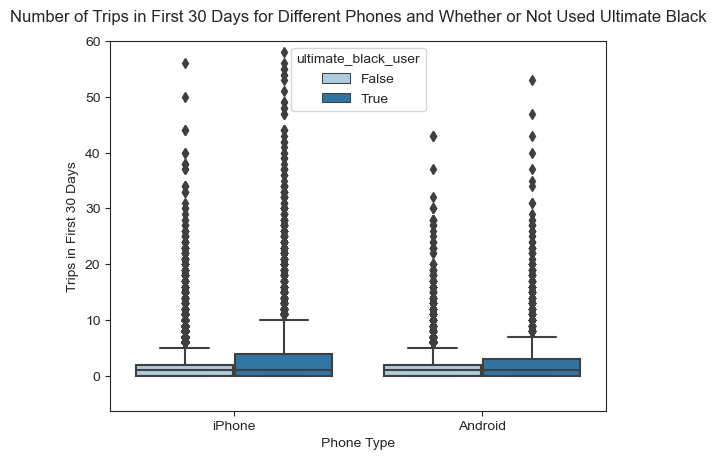

In [23]:
#Next, let's use boxplots to compare ultimate_black_user to trips_in_first_30_days 
sns.set_style("ticks")
ax = sns.boxplot(x='phone', y='trips_in_first_30_days', hue='ultimate_black_user', data=df, palette='Paired')
ax.set_xlabel('Phone Type')
ax.set_ylabel('Trips in First 30 Days')
ax.set_ylim(top=60)
ax.set_title("Number of Trips in First 30 Days for Different Phones and Whether or Not Used Ultimate Black", y=1.03)

This plot shows us that riders who used Ultimate Black in their first 30 days also took more trips, and also that iPhone users who used Ultimate Black also took more trips in their first 30 days than Android users. The plots above include both retained and non-retained users. Let's look at a few more plots that show only non-retained users to see if there are any obvious patterns.

In [24]:
#the easiest way to do that is make a copy of the df containing only non-retained users:
non_retained = df[df['retained'] == 0]


Text(0.5, 1.0, 'Non-Retained Users by Ultimate Black User Type')

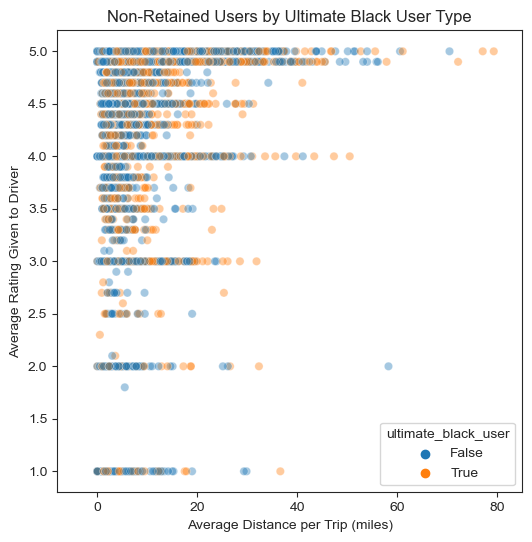

In [25]:
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.scatterplot(data=non_retained, x='avg_dist', y='avg_rating_of_driver', hue = 'ultimate_black_user', alpha = 0.4)

ax.set_xlabel('Average Distance per Trip (miles)')
ax.set_ylabel('Average Rating Given to Driver')
ax.set_xlim(right=85)
ax.set_title("Non-Retained Users by Ultimate Black User Type")

From this plot, we can see that the rating given to a driver generally is a little higher for longer trips, lots of users always give the same rating (based on bands at the whole numbers for average rating), and there does not seems to be much of a relationship between whether or not a rider used Ultimate Black and the rating they give their driver or their average trip length.

### Additional Preprocessing
Since our problem is one of binary classification, before I begin modeling, it would be nice to know how balanced the two classes are:

In [26]:
df['retained'].value_counts()

1    34610
0    15390
Name: retained, dtype: int64

In [27]:

print(f'Retained riders make up {34610/50000:.2f}% of users.')

Retained riders make up 0.69% of users.


So our classes are not balanced, but they are not extremely imbalanced. I do not think any extraordinary measures like oversampling the non-retained class need to be taken to deal with the slight imbalance.

In [28]:
# drop date columns to prepare a final df for modeling 
# 'trips_in_first_30_days' needs to be dropped also, because this is how the 'retained' feature is determined.

df_feat = df.drop(['trips_in_first_30_days','signup_date', 'last_trip_date'], axis=1)
df_feat.head()

,city,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,1


In [29]:
#ultimate_black_user with 0,1 (the other two categorical variables will be one-hot encoded after train-test split)

df_feat['ultimate_black_user'] = df_feat['ultimate_black_user'].astype(int)

In [30]:
#train-test split using 85% for training. 
#Stratify y tries to preserve the proportions among the classes in the original dataset

X = df_feat.drop(columns = ['retained'])
y = df_feat[['retained']]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.85, random_state = 47, stratify = y)

In [31]:
#scale avg_dist, surge_pct, avg_rating_of_driver, and avg_rating_by_driver cols
scaler = StandardScaler()
cols_to_scale = ['avg_dist', 'surge_pct', 'avg_rating_of_driver', 'avg_rating_by_driver','weekday_pct']
Xtrain[cols_to_scale] = scaler.fit_transform(Xtrain[cols_to_scale])
Xtest[cols_to_scale] = scaler.transform(Xtest[cols_to_scale])

In [32]:
display(Xtrain.head(3), Xtest.head(3))

,city,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
3579,King's Landing,0.606703,1.0,iPhone,-0.444212,0,1.053839,-0.738478,0.494951
32073,Winterfell,0.433796,1.0,Android,-0.444212,0,-1.641654,1.274588,0.494951
32706,Winterfell,0.433796,1.0,iPhone,-0.444212,0,1.053839,-0.452393,0.494951


,city,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
14343,Astapor,0.087980,1.00,iPhone,-0.444212,1,1.053839,-0.150607,0.271773
21495,Astapor,0.087980,1.08,iPhone,1.222585,0,1.053839,1.208300,-0.174583
1983,Astapor,0.606703,1.13,iPhone,0.391689,0,0.603692,-0.534381,-0.174583


In [33]:
#one-hot encode Xtrain and Xtest seperately after split

cat_cols = ['city','phone']
Xtrain_cat = Xtrain[['city','phone']]
Xtest_cat = Xtest[['city','phone']]

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

encoder.fit(Xtrain_cat)
Xtrain.drop(columns = cat_cols, inplace=True)
Xtrain_cat = pd.DataFrame(encoder.transform(Xtrain_cat), index = Xtrain.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
Xtrain = Xtrain.join(Xtrain_cat, how ='outer')

encoder.fit(Xtest_cat)
Xtest.drop(columns = cat_cols, inplace=True)
Xtest_cat = pd.DataFrame(encoder.transform(Xtest_cat), index = Xtest.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
Xtest = Xtest.join(Xtest_cat, how ='outer')

display(Xtrain.head(3), Xtest.head(3), ytrain.head(3), ytest.head(3))

C:\Users\ehard\anaconda3\envs\ultimate_takehome\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ehard\anaconda3\envs\ultimate_takehome\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
3579,0.606703,1.0,-0.444212,0,1.053839,-0.738478,0.494951,1,0,1
32073,0.433796,1.0,-0.444212,0,-1.641654,1.274588,0.494951,0,1,0
32706,0.433796,1.0,-0.444212,0,1.053839,-0.452393,0.494951,0,1,1


,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
14343,0.087980,1.00,-0.444212,1,1.053839,-0.150607,0.271773,0,0,1
21495,0.087980,1.08,1.222585,0,1.053839,1.208300,-0.174583,0,0,1
1983,0.606703,1.13,0.391689,0,0.603692,-0.534381,-0.174583,0,0,1


,retained
3579,1
32073,1
32706,0


,retained
14343,1
21495,1
1983,1


So now the train and test sets are ready for modeling.

### Modeling:
There are many model options available for binary classification, including several that have good interpretability, which is key in this situation because we need to know what factors drive rider retention. Logistic regression and decision tree classification are both highly interpretable.

In [34]:
#Logistic Regression Classifier

clf = LogisticRegression(solver = 'newton-cg', max_iter = 500, class_weight='balanced', random_state = 47)

In [35]:
# fit the classifier

clf.fit(Xtrain, ytrain.values.ravel()) 

LogisticRegression(class_weight='balanced', max_iter=500, random_state=47,
                   solver='newton-cg')

In [36]:
# predict on training and test sets

y_pred_train = clf.predict(Xtrain)

y_pred_test = clf.predict(Xtest)

In [37]:
#display train and test accuracy

print('Training Data Accuracy Score:', f'{accuracy_score(y_pred_train, ytrain):.2f}')
print('Test Data Accuracy Score:', f'{accuracy_score(y_pred_test, ytest):.2f}')
       

Training Data Accuracy Score: 0.57
Test Data Accuracy Score: 0.57


In [38]:
# let's also try with a different solver, the 'newton-cholesky' solver which is good when 
# n_samples >> n_features and is used for binary classification. Let's also try no penalty.

NC_clf = LogisticRegression(penalty = None, solver = 'newton-cholesky', class_weight='balanced', max_iter = 500, random_state = 47)

NC_clf.fit(Xtrain, ytrain.values.ravel()) 

LogisticRegression(class_weight='balanced', max_iter=500, penalty=None,
                   random_state=47, solver='newton-cholesky')

In [39]:
# predict on training and test sets

y_pred_train_nc = NC_clf.predict(Xtrain)

y_pred_test_nc = NC_clf.predict(Xtest)

In [40]:
#display train and test accuracy

print('Training Data Accuracy Score:', f'{accuracy_score(y_pred_train_nc, ytrain):.2f}')
print('Test Data Accuracy Score:', f'{accuracy_score(y_pred_test_nc, ytest):.2f}')

Training Data Accuracy Score: 0.57
Test Data Accuracy Score: 0.57


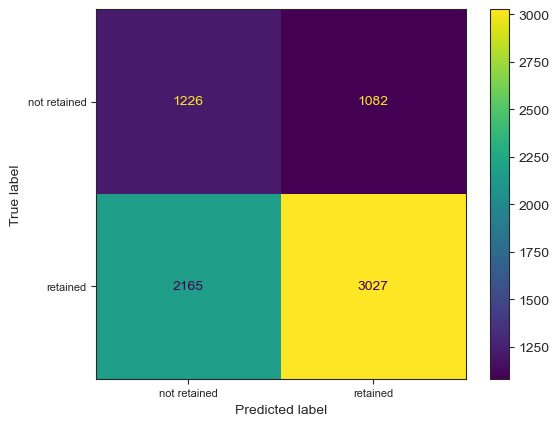

In [41]:
# let's look at the confusion matrix for the LR model:
cm = confusion_matrix(ytest, y_pred_test, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['not retained', 'retained'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['not retained', 'retained'], fontsize = 8)
ax.set_yticklabels(labels = ['not retained', 'retained'], fontsize = 8)
display_cm.plot(ax = ax)

From the confusion matrix, we can see that Logistic Regression is giving a very high false positive rate (2290 out of 2290+5176, or about 44%), meaning the model is predicting a rider will be retained when they are actually not.
Let's see how a Decision Tree Classifier model does. Decision Tree Classifier models have a lot more parameters to tune, so I will implement a grid search method to identify the best hyper-parameter values for the criterion and max_depth. 

In [42]:
#set up a parameter grid of different values for GridSearchCV of criterion and max depth
criterions = ['gini', 'entropy']
max_depth = [2,5,7,10,20,30]

param_grid = {
        'criterion': criterions,
        'max_depth': max_depth
}
param_grid

{'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 7, 10, 20, 30]}

In [94]:
#create instance of base model
dtc = DecisionTreeClassifier()

#create instance of RandomSearchCV
dtc_cv = GridSearchCV(dtc, param_grid=param_grid, cv=5)

# Fit the random search model using reduced feature space X set
dtc_cv.fit(Xtrain, ytrain.values.ravel())

dtc_cv.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [43]:
# Execute a model with the best params found above
dt_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth = 5, random_state=47)

# fit the model
dt_clf.fit(Xtrain, ytrain.values.ravel())

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
ytest_pred = dt_clf.predict(Xtest)


In [44]:
# evaluate the model
print("Decision Tree Classifier with Entropy criterion and max_depth=5")
print("Accuracy:", metrics.accuracy_score(ytest, ytest_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(ytest, ytest_pred))
print('Precision score for "Retained"' , metrics.precision_score(ytest, ytest_pred, pos_label = 1))
print('Recall score for "Not-Retained"' , metrics.recall_score(ytest, ytest_pred, pos_label = 0))

Decision Tree Classifier with Entropy criterion and max_depth=5
Accuracy: 0.6938666666666666
Balanced accuracy: 0.5176416256979809
Precision score for "Retained" 0.7000552638850511
Recall score for "Not-Retained" 0.059358752166377815


In [48]:
from sklearn.ensemble import RandomForestClassifier

#set up a parameter grid of different values for GridSearchCV of criterion and max depth
n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=8)]
criterions = ['gini', 'entropy']
max_depth = [2,5,7,10,20,30]

rf_param_grid = {
        'n_estimators': n_est,
        'criterion': criterions,
        'max_depth': max_depth
}
rf_param_grid

{'n_estimators': [10, 16, 26, 43, 71, 117, 193, 316],
 'criterion': ['gini', 'entropy'],
 'max_depth': [2, 5, 7, 10, 20, 30]}

In [98]:
#create instance of base model
rfclf = RandomForestClassifier()

#create instance of RandomSearchCV
rfclf_cv = GridSearchCV(rfclf, param_grid = rf_param_grid, cv=5)

# Fit the random search model using reduced feature space X set
rfclf_cv.fit(Xtrain, ytrain.values.ravel())

rfclf_cv.best_params_

In [49]:
# Execute a model with the best params found above
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=193, max_depth = 10, random_state=47)

# fit the model
rf_clf.fit(Xtrain, ytrain.values.ravel())

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
ytest_pred = rf_clf.predict(Xtest)


In [50]:
# evaluate the model
print("Random Forest Classifier with Entropy criterion, num estimators=193, and max_depth=10")
print("Accuracy:", metrics.accuracy_score(ytest, ytest_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(ytest, ytest_pred))
print('Precision score for "Retained"' , metrics.precision_score(ytest, ytest_pred, pos_label = 1))
print('Recall score for "Not-Retained"' , metrics.recall_score(ytest, ytest_pred, pos_label = 0))

Random Forest Classifier with Entropy criterion, num estimators=193, and max_depth=10
Accuracy: 0.6988
Balanced accuracy: 0.5325163629954629
Precision score for "Retained" 0.706928178354734
Recall score for "Not-Retained" 0.10008665511265165


In [51]:
%%capture --no-display

from xgboost import XGBClassifier

In [48]:
#set up a parameter grid for hyperparameter Random CV search:

n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=10)]
max_depth = [0,3,6,9]
learn_rate = [0.1,0.2,0.3,0.4,0.5]

xgb_param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth,
        'learning_rate':learn_rate
}
xgb_param_grid

{'n_estimators': [10, 14, 21, 31, 46, 68, 100, 146, 215, 316],
 'max_depth': [0, 3, 6, 9],
 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [63]:
%%capture --no-display
#create XGB model instance
xgb_clf = XGBClassifier()

#create instance of RandomSearchCV
xgb_cv = GridSearchCV(xgb_clf, param_grid=xgb_param_grid, cv=5)

# Fit the random search model using reduced feature space X set
xgb_cv.fit(Xtrain, ytrain.values.ravel())

xgb_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 21}

In [52]:
# Execute a model with the best params found above
xgb_clf = XGBClassifier(n_estimators=21, max_depth = 3, learning_rate = 0.5, random_state=47)

# fit the model
xgb_clf.fit(Xtrain, ytrain.values.ravel())

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
ytest_pred = xgb_clf.predict(Xtest)


In [53]:
# evaluate the model
print("XGBoost Classifier with learning_Rate=0.5, num estimators=21, and max_depth=3")
print("Accuracy:", metrics.accuracy_score(ytest, ytest_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(ytest, ytest_pred))
print('Precision score for "Retained"' , metrics.precision_score(ytest, ytest_pred, pos_label = 1))
print('Recall score for "Not-Retained"' , metrics.recall_score(ytest, ytest_pred, pos_label = 0))

XGBoost Classifier with learning_Rate=0.5, num estimators=21, and max_depth=3
Accuracy: 0.696
Balanced accuracy: 0.5324193933875072
Precision score for "Retained" 0.7069945976684674
Recall score for "Not-Retained" 0.10701906412478336


## Feature Importances of the Various Models

In [85]:
#get coefficients for Logistic Regression model
coefficients = np.exp(clf.coef_[0])
feature_names = clf.feature_names_in_
print(coefficients, feature_names)

[0.9027155  0.94744482 1.03411148 1.22870921 1.00794318 0.86164233
 0.99574722 0.91085036 1.25460595 0.98429376] ['avg_rating_of_driver' 'avg_surge' 'surge_pct' 'ultimate_black_user'
 'weekday_pct' 'avg_dist' 'avg_rating_by_driver' "city_King's Landing"
 'city_Winterfell' 'phone_iPhone']


In [97]:
pd.DataFrame(coefficients, feature_names, columns=['coefficients']).sort_values(by='coefficients', ascending=False)


,coefficients
city_Winterfell,1.254606
ultimate_black_user,1.228709
surge_pct,1.034111
weekday_pct,1.007943
avg_rating_by_driver,0.995747
phone_iPhone,0.984294
avg_surge,0.947445
city_King's Landing,0.910850
avg_rating_of_driver,0.902715
avg_dist,0.861642


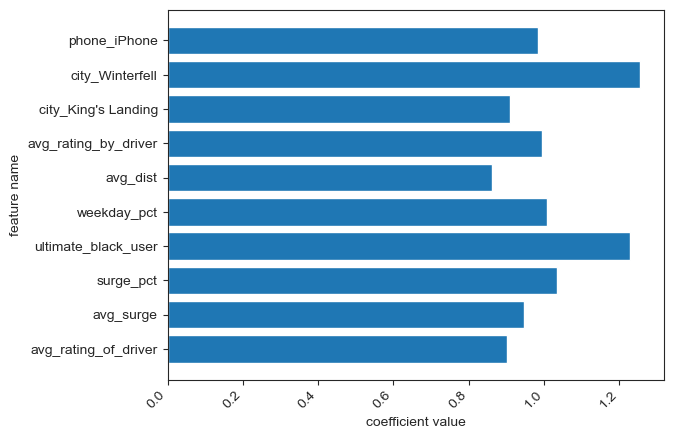

In [92]:
fig, ax = plt.subplots()
ax.barh(feature_names, coefficients)
ax.set(ylabel='feature name', xlabel='coefficient value')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

So for the Logistic Regression model, being located in Winterfell and being an Ultimate Black user were indicators of slightly elevated chances of being retained, but not by a lot. This model balanced the class weights to try to make up for the class imbalance, but it did not perform very well in terms of accuracy. Below I will use the SHAP library to explore the feature importances of the Random Forest and XGBoost models. SHAP (SHapely Additive exPlanations) is a game theory-based approach to explain the output of a machine learning model that quantifies the contribution that each feature brings to one observation predction made by the model.

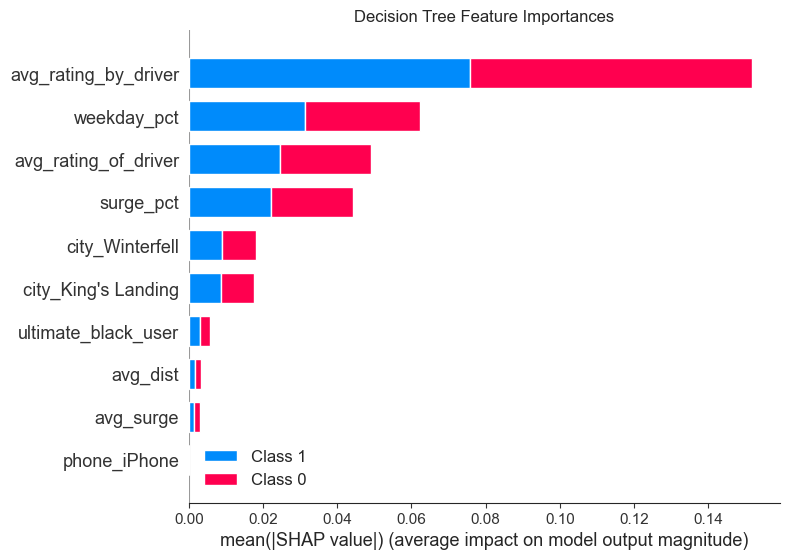

In [102]:
# calculate shap values for each feature from the Decision Tree model and plot
import shap
explainer_dt = shap.explainers.Tree(dt_clf)
shap_values_dt = explainer_dt.shap_values(Xtest)
shap.summary_plot(shap_values_dt, Xtest, plot_type='bar', show=False)
plt.title('Decision Tree Feature Importances')
plt.show()

So, the avg_rating_by_driver and weekday_percent are the two most important features for predicting both retained and non-retained users. This makes sense, as weekday users might be more likely to be regular riders, and the rating given to the rider by a driver is likely indicative of whether the rider had a good experience or not (if they had a good experience they are more likely to ride again, and if they had a bad experience they are less likely to ride again).

In [60]:
# calculate shap values for each feature from the Random Forest model

explainer = shap.explainers.Tree(rf_clf)
shap_values = explainer.shap_values(Xtest)

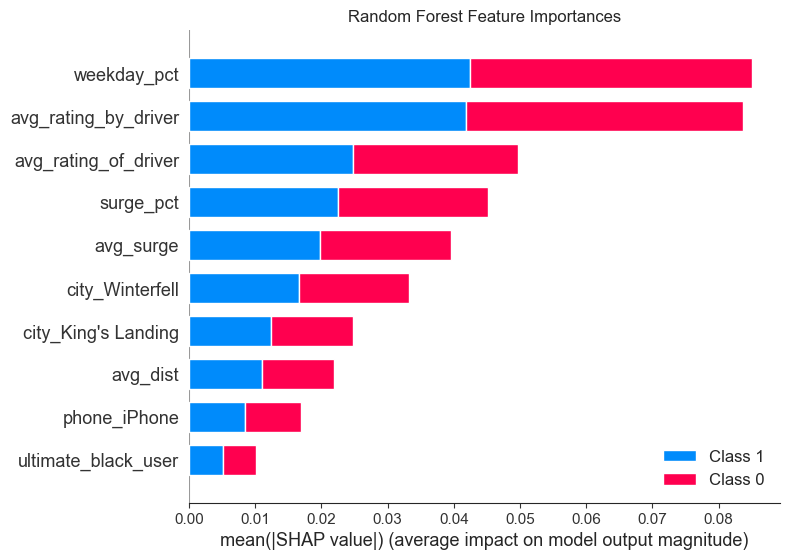

In [101]:
shap.summary_plot(shap_values, Xtest, plot_type='bar', show=False)
plt.title('Random Forest Feature Importances')
plt.show()

Again, with the Random Forest model the weekday_percent and avg_rating_by_driver are the two most important features for predicting both retained and non-retained users. 

In [63]:
# calculate shap values for each feature from the XGBoost model

explainer_xgb = shap.explainers.Tree(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(Xtest)

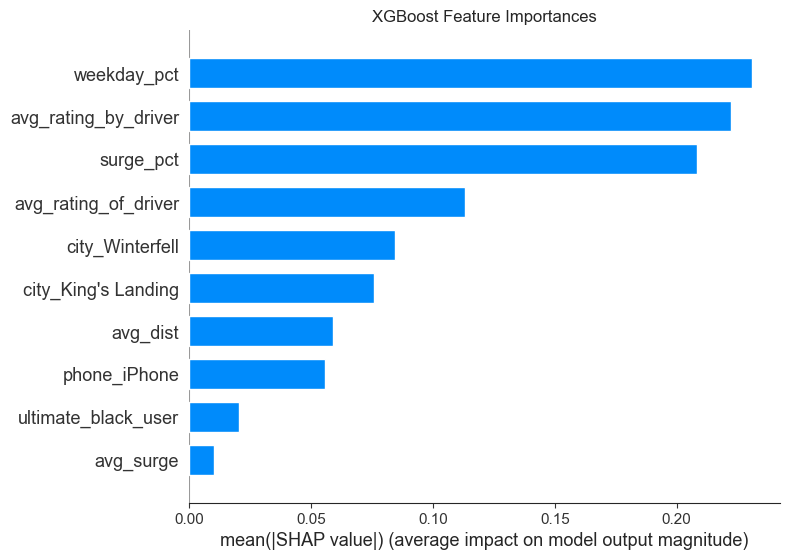

In [103]:
shap.summary_plot(shap_values_xgb, Xtest, plot_type='bar', show=False)
plt.title('XGBoost Feature Importances')
plt.show()

The XGBoost model has the same top two most important features. Since there is some consensus from different models about importance of these two features, these two might be worth targeting as features to explore in a marketing campaign or similar.

## Leveraging Insights

A consensus among the various predicictiv models tried is that weekday_pct and avg_rating_by_driver are important features in determining whether or not a rider will be retained. Therefore, programs that aim to increase the rides taken during the week and that make sure the rider has a good experience (and the driver also gives a good rating to the rider) should be implemented. For example, after taking their first ride with Ultimate and periodically thereafter, users could be given a coupon for 50% off a weekday ride. Another possible idea would be to send the highest-rated drivers with the nicest vehicles (when there are multiple driver options for a ride pickup) to pick up riders who are new to the platform, to ensure that new users have an excellent experience.